[View in Colaboratory](https://colab.research.google.com/github/jasonrwang/ghg_analytics/blob/master/ghg_analytics.ipynb)

# ghg_analytics
## Insights into trends with global greenhouse gases and climate change action.

### Authors:
* Aashna Mittal
* Gamze Ünlü
* Jason R Wang

In [149]:
#library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import NaN
plt.style.use('ggplot')

## Data Cleaning

In [154]:
#Import data on Greenhouse Gases
GreenhouseGasesOriginalDf = pd.read_csv("Data Sources/GreenhouseGasData.csv", sep=',', skipinitialspace=True, skiprows=4) 
#print("Original dataframe...\n", GreenhouseGasesOriginalDf.head(10))

#Drop the indicator name and indicator code as the values are same across the whole dataframe
GreenhouseGasesDf = GreenhouseGasesOriginalDf.drop(["Indicator Code", "Indicator Name"], axis = 1)

#Drop all the columns that contain only null values
GreenhouseGasesDf = GreenhouseGasesDf.dropna(axis = 1, how="all")  

#Drop all the rows that contain only null values, starting from column 2
GreenhouseGasesDf = GreenhouseGasesDf.dropna(axis = 0, how="all", subset = GreenhouseGasesDf.columns[2:])  

#First interpolate missing values and then use backfill to fill starting NA values of a row
GreenhouseGasesDf.iloc[:,2:] = GreenhouseGasesDf.iloc[:,2:].interpolate(axis = 1).bfill(axis=1)

GreenhouseGasesDf

,Country Name,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Aruba,ABW,4.230630e+01,4.278695e+01,4.328661e+01,4.372459e+01,4.413096e+01,4.448191e+01,1.316337e+02,1.350553e+02,...,6.169287e+02,6.169287e+02,6.169287e+02,6.169287e+02,6.169287e+02,6.169287e+02,6.169287e+02,6.169287e+02,6.169287e+02,6.169287e+02
1,Afghanistan,AFG,1.430662e+04,1.439178e+04,1.304085e+04,1.353575e+04,1.494597e+04,1.457416e+04,1.474685e+04,1.524728e+04,...,1.470988e+04,1.465437e+04,1.477026e+04,1.484916e+04,1.527263e+04,1.528878e+04,1.555443e+04,1.779133e+04,1.798131e+04,1.816886e+04
2,Angola,AGO,6.064860e+04,3.916217e+04,4.220565e+04,4.425267e+04,4.017923e+04,4.442930e+04,3.844802e+04,4.356341e+04,...,3.585801e+04,3.686023e+04,3.585574e+04,3.637582e+04,3.669053e+04,3.739629e+04,3.830947e+04,4.002939e+04,4.087865e+04,4.165716e+04
3,Albania,ALB,6.960868e+03,6.950036e+03,7.613266e+03,7.348492e+03,7.632664e+03,7.873037e+03,8.470978e+03,8.948981e+03,...,7.834016e+03,7.401102e+03,8.308386e+03,8.027150e+03,9.879394e+03,8.136785e+03,8.108812e+03,8.506996e+03,8.712296e+03,8.898641e+03
5,Arab World,ARB,5.523621e+05,5.769462e+05,6.250159e+05,6.992802e+05,6.794480e+05,6.839662e+05,7.758637e+05,7.999710e+05,...,1.963193e+06,1.660587e+06,1.767879e+06,1.731289e+06,2.355481e+06,2.364089e+06,2.387502e+06,1.924245e+06,2.483349e+06,1.908696e+06
6,United Arab Emirates,ARE,3.296219e+04,4.137785e+04,4.490546e+04,5.687551e+04,5.741153e+04,5.779860e+04,7.035262e+04,6.964640e+04,...,1.340917e+05,1.399995e+05,1.433677e+05,1.518373e+05,1.679864e+05,1.813885e+05,1.824222e+05,1.931272e+05,1.993425e+05,2.048887e+05
7,Argentina,ARG,2.219570e+05,2.135518e+05,2.239123e+05,2.269560e+05,2.294564e+05,2.334168e+05,2.470517e+05,2.473709e+05,...,3.447971e+05,3.699441e+05,3.583856e+05,3.736006e+05,3.845478e+05,4.115036e+05,3.734091e+05,3.646843e+05,3.728731e+05,3.802953e+05
8,Armenia,ARM,6.245988e+03,6.383672e+03,6.750824e+03,7.371758e+03,7.983875e+03,1.162704e+04,1.192939e+04,1.241337e+04,...,6.973881e+03,7.633471e+03,8.401816e+03,8.743509e+03,9.323718e+03,1.246998e+04,1.123509e+04,1.139304e+04,1.241774e+04,1.231939e+04
9,American Samoa,ASM,1.307336e+01,1.324733e+01,1.344811e+01,1.367533e+01,1.390883e+01,1.419287e+01,1.438352e+01,1.464980e+01,...,5.183834e+01,5.232038e+01,5.280118e+01,5.330204e+01,5.391398e+01,5.461632e+01,5.498935e+01,5.663749e+01,5.774351e+01,5.876552e+01
10,Antigua and Barbuda,ATG,3.130334e+02,3.130334e+02,3.130334e+02,3.130334e+02,3.130334e+02,3.130334e+02,3.130334e+02,3.130334e+02,...,4.188380e+02,4.490025e+02,4.540706e+02,4.635657e+02,4.780839e+02,4.918974e+02,5.072002e+02,5.225030e+02,5.378058e+02,5.527479e+02


## Data visualization

Text(0,0.5,'GreenHouse Emission [Kt CO2]')

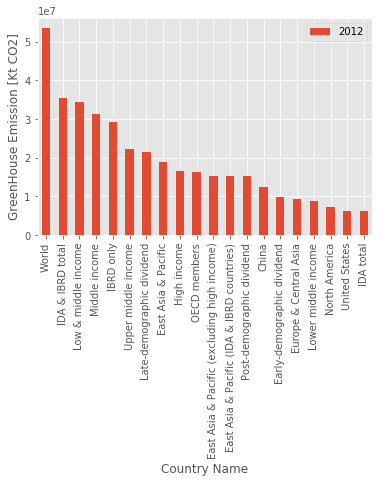

In [155]:
#Sorted bar chart of 2012 greenhouse gases

"""TODO:

1. Create a new dataframe which contains only the country data
2. Import list of aggregates
3. Drop these rows from existing dataframe to create a new country dataframe and only use that for plotting
#Source: https://datahelpdesk.worldbank.org/knowledgebase/articles/898614-api-aggregates-regions-and-income-levels"""

GreenhouseGasesDf.sort_values(by="2012", ascending=False)[["Country Name", "2012"]]

GreenhouseGasesTop20Emitters = GreenhouseGasesDf.sort_values(by = "2012", ascending = False).iloc[:20,:]

GreenhouseGasesTop20Emitters[["Country Name", "2012"]].plot(x = "Country Name", kind="bar")

plt.ylabel("GreenHouse Emission [Kt CO2]")